In [2]:
# import the required libraries
import numpy as np
import time
import random
import pickle as cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [3]:
!pip install -qU svgwrite

In [4]:
import svgwrite # conda install -c omnia svgwrite=1.1.6

In [5]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)

INFO:tensorflow:TensorFlow Version: 1.15.0


In [6]:
!pip install -q magenta

In [7]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

/home/xuyue-pub/miniforge3/envs/sketch_rnn/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [8]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

In [9]:
data_dir = './QuickDraw_generation'
models_root_dir = './logs'   
model_dir = './logs'

In [10]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [11]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

INFO:tensorflow:Loaded 70000/2500/2500 from airplane.npz
INFO:tensorflow:Loaded 70000/2500/2500 from alarm_clock.npz
INFO:tensorflow:Loaded 70000/2500/2500 from angel.npz
INFO:tensorflow:Loaded 70000/2500/2500 from apple.npz
INFO:tensorflow:Loaded 70000/2500/2500 from belt.npz
INFO:tensorflow:Loaded 70000/2500/2500 from bus.npz
INFO:tensorflow:Loaded 70000/2500/2500 from butterfly.npz
INFO:tensorflow:Loaded 70000/2500/2500 from cake.npz
INFO:tensorflow:Loaded 70000/2500/2500 from cat.npz
INFO:tensorflow:Loaded 70000/2500/2500 from clock.npz
INFO:tensorflow:Dataset combined: 750000 (700000/25000/25000), avg len 61
INFO:tensorflow:model_params.max_seq_len 148.
total images <= max_seq_len is 700000
total images <= max_seq_len is 25000
total images <= max_seq_len is 25000
INFO:tensorflow:normalizing_scale_factor 49.6908.


In [12]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.


INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Outp

In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [14]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model ./logs/vector-62000.
INFO:tensorflow:Restoring parameters from ./logs/vector-62000


In [15]:
with open(models_root_dir + "/model_config.json", 'r', encoding='utf-8') as f:
        config = json.load(f)
max_seq_len = config.get('max_seq_len', 250)

print(max_seq_len)

148


In [77]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes,max_seq_len).tolist()
  #draw_strokes(np.array(strokes))
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [17]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

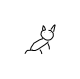

In [98]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke) 


Let's try to encode the sample stroke into latent vector $z$

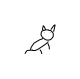

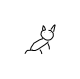

In [99]:
z = encode(stroke)
draw_strokes(stroke, svg_filename=os.path.join("temperature_example", 't2_r.svg'))

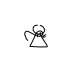

In [100]:
_ = decode(z, temperature=0.1) # convert z back to drawing at temperature of 0.8

Create generated grid at various temperatures from 0.1 to 1.0

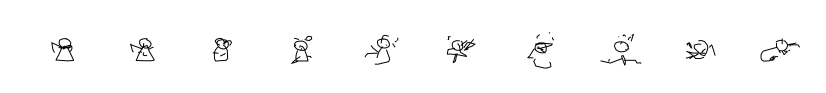

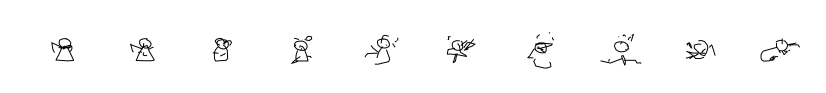

In [101]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.2*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)
draw_strokes(stroke_grid, svg_filename=os.path.join("temperature_example", 't2.svg'))

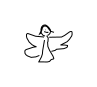

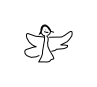

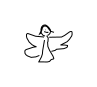

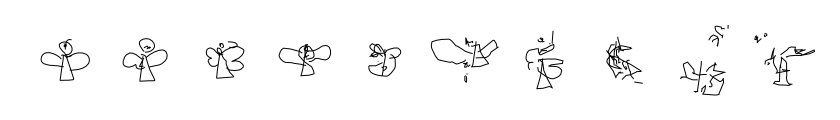

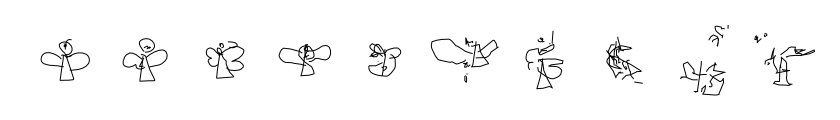

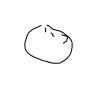

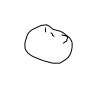

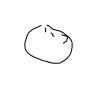

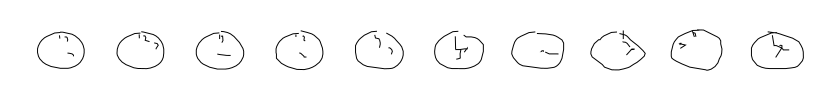

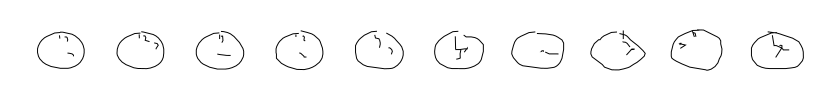

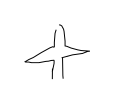

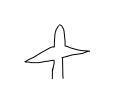

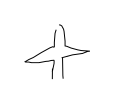

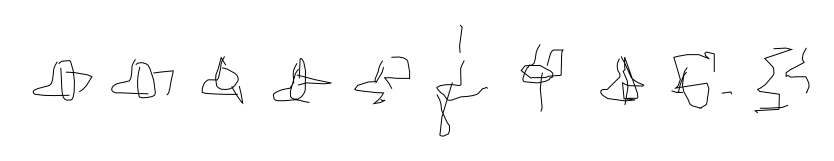

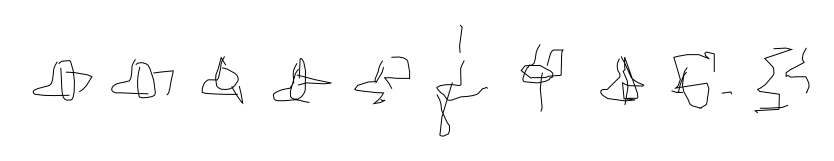

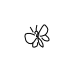

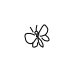

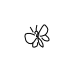

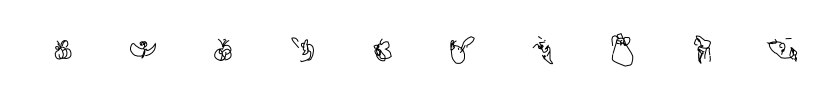

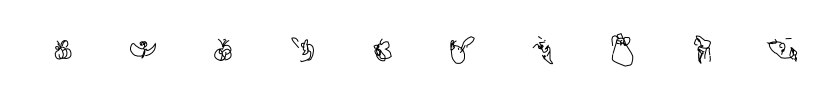

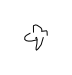

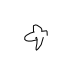

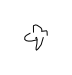

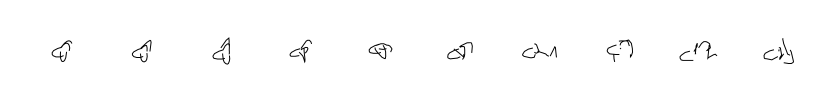

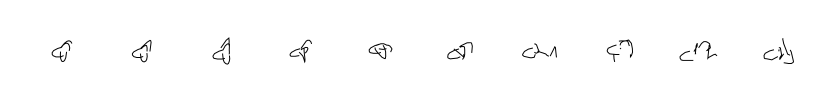

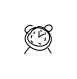

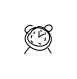

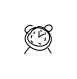

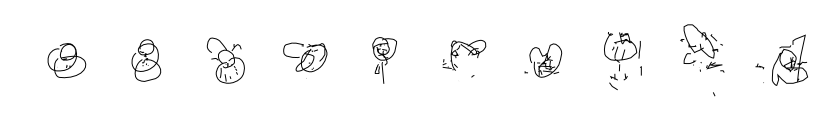

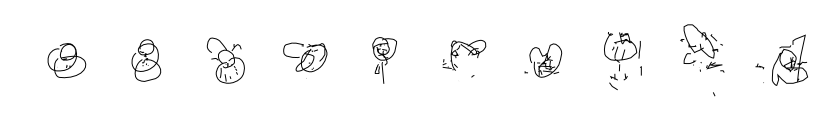

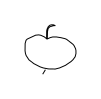

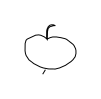

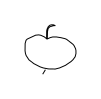

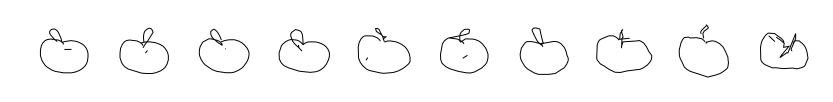

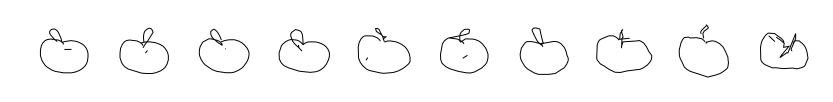

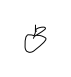

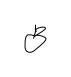

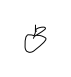

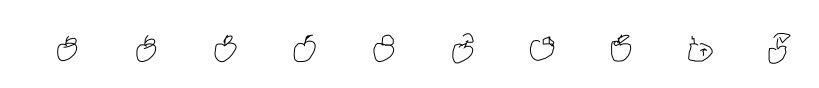

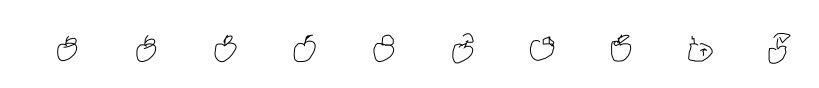

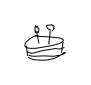

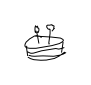

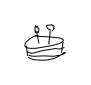

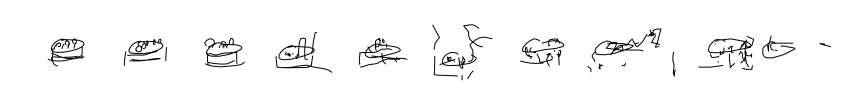

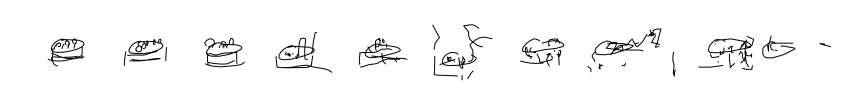

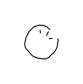

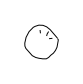

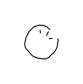

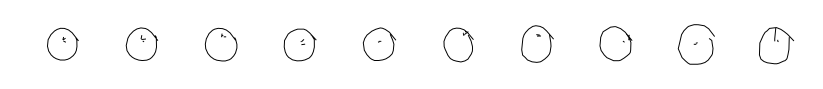

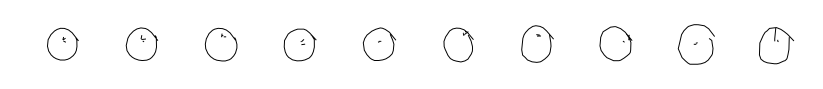

In [102]:
# get a sample drawing from the test set, and render it to .svg
for j in range(10):
    stroke = test_set.random_sample()
    draw_strokes(stroke) 
    z = encode(stroke)
    draw_strokes(stroke, svg_filename=os.path.join("temperature_example", 't'+str(j)+'_r.svg'))
    stroke_list = []
    for i in range(10):
        stroke_list.append([decode(z, draw_mode=False, temperature=0.2*i+0.1), [0, i]])
    stroke_grid = make_grid_svg(stroke_list)
    draw_strokes(stroke_grid)
    draw_strokes(stroke_grid, svg_filename=os.path.join("temperature_example", 't'+str(j)+'.svg'))

Latent Space Interpolation Example between $z_0$ and $z_1$

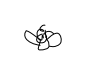

In [22]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

stroke3


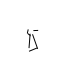

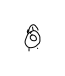

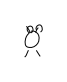

In [ ]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

Now we interpolate between sheep $z_0$ and sheep $z_1$

In [24]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [25]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

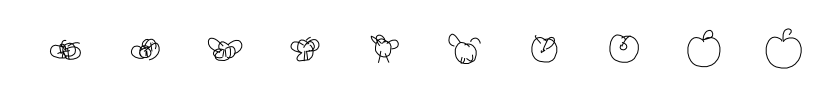

In [26]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

In [ ]:
stroke = test_set.random_sample()

draw_strokes(stroke_grid, svg_filename=os.path.join("interpolation_example", 'i'+str(j)+'.svg'))
z0 = encode(stroke)
_ = decode(z0)

stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

In [130]:
stroke = test_set.random_sample()
detect_stroke_format(stroke)

'stroke3'

In [131]:
for j in range(10):
  stroke = test_set.random_sample()
  np.save(os.path.join("interpolation_example_s2",'z0_i'+str(j)+'.npy'), stroke)
  draw_strokes(stroke, svg_filename=os.path.join("interpolation_example_s2", 'z0_i'+str(j)+'.svg'))
  z0 = encode(stroke)
  _ = decode(z0)

  stroke = test_set.random_sample()
  np.save(os.path.join("interpolation_example_s2", 'z1_i'+str(j)+'.npy'), stroke)
  draw_strokes(stroke, svg_filename=os.path.join("interpolation_example_s2", 'z1_i'+str(j)+'.svg'))
  z1 = encode(stroke)
  _ = decode(z1)

  z_list = [] # interpolate spherically between z0 and z1
  N = 10
  for t in np.linspace(0, 1, N):
    z_list.append(slerp(z0, z1, t))

  # for every latent vector in z_list, sample a vector image
  reconstructions = []
  for i in range(N):
    reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])
    
  stroke_grid = make_grid_svg(reconstructions)
  draw_strokes(stroke_grid, svg_filename=os.path.join("interpolation_example_s2", 'i'+str(j)+'.svg'))

FileNotFoundError: [Errno 2] No such file or directory: 'interpolation_example_s2/z0_i0.npy'

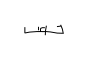

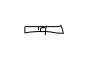

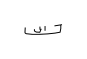

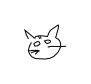

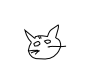

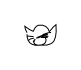

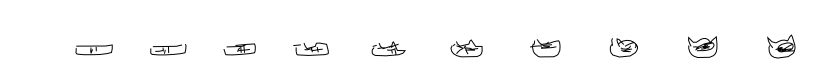

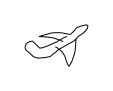

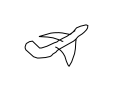

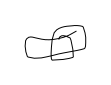

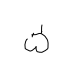

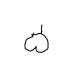

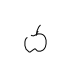

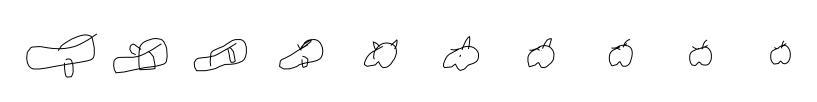

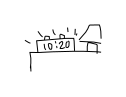

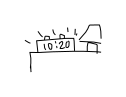

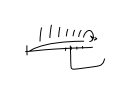

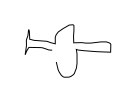

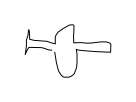

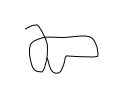

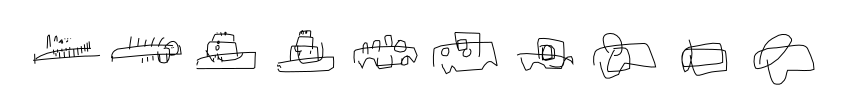

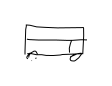

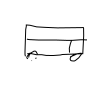

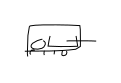

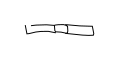

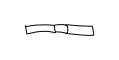

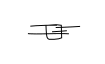

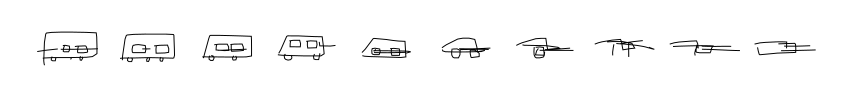

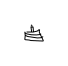

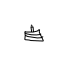

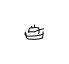

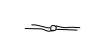

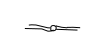

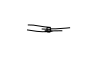

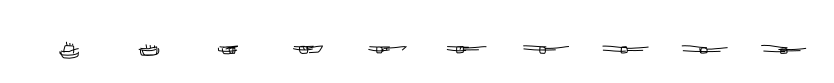

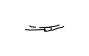

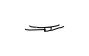

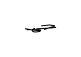

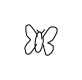

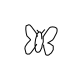

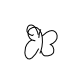

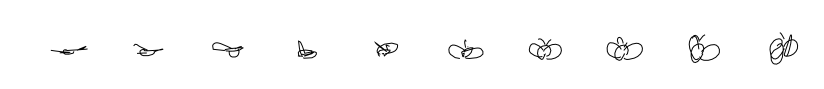

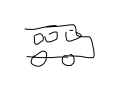

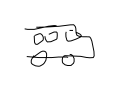

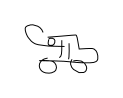

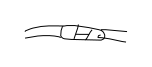

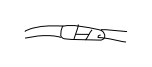

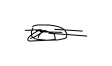

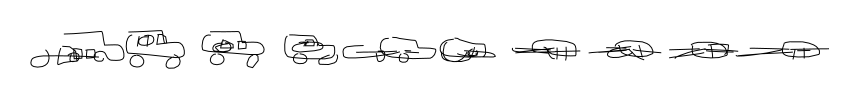

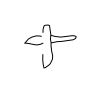

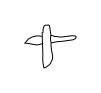

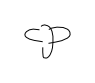

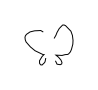

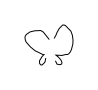

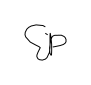

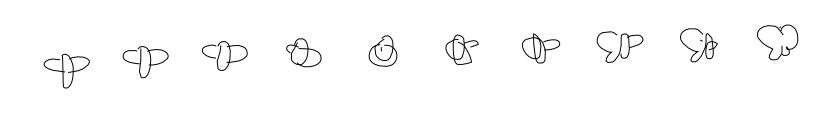

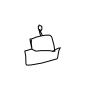

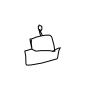

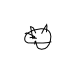

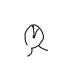

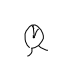

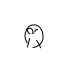

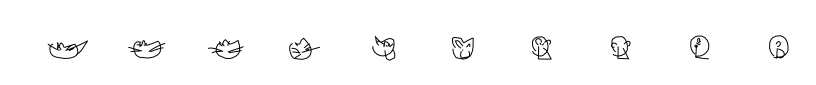

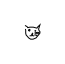

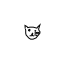

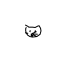

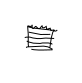

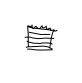

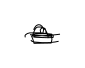

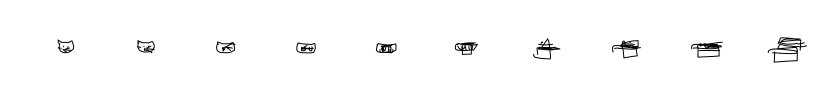

In [106]:
for j in range(10):
  stroke = test_set.random_sample()
  draw_strokes(stroke, svg_filename=os.path.join("interpolation_example", 'z0_i'+str(j)+'.svg'))
  z0 = encode(stroke)
  _ = decode(z0)

  stroke = test_set.random_sample()
  draw_strokes(stroke, svg_filename=os.path.join("interpolation_example", 'z1_i'+str(j)+'.svg'))
  z1 = encode(stroke)
  _ = decode(z1)

  z_list = [] # interpolate spherically between z0 and z1
  N = 10
  for t in np.linspace(0, 1, N):
    z_list.append(lerp(z0, z1, t))

  # for every latent vector in z_list, sample a vector image
  reconstructions = []
  for i in range(N):
    reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])
    
  stroke_grid = make_grid_svg(reconstructions)
  draw_strokes(stroke_grid, svg_filename=os.path.join("interpolation_example", 'i'+str(j)+'.svg'))

### s3和s5的检测和转换函数

In [129]:
def detect_stroke_format(arr):
    arr = np.asarray(arr)
    if arr.ndim != 2:
        return 'unknown'
    ncols = arr.shape[1]
    if ncols == 3:
        return 'stroke3'
    if ncols == 5:
        return 'stroke5'
    # heuristic: if last 3 columns look like a one-hot/probability vector -> stroke5
    if ncols >= 3:
        last3 = arr[:, -3:]
        sums = last3.sum(axis=1)
        if np.allclose(sums, 1.0, atol=1e-6):
            return 'stroke5'
    return 'unknown'


def to_stroke5(strokes, max_len=None):
    """Convert stroke3-like array (N x 3) to stroke5 (big strokes).
    This uses `to_big_strokes` which expects "normal" stroke format (dx, dy, pen_state) and
    returns a 5-dim array (dx, dy, p1, p2, p3).
    """
    strokes = np.asarray(strokes)
    # If already stroke5, return copy
    if detect_stroke_format(strokes) == 'stroke5':
        return strokes.copy()
    # If shape (N,3) possibly with absolute coords, assume it's normal strokes accepted by to_big_strokes
    # to_big_strokes signature: to_big_strokes(stroke, max_len=...)
    if max_len is None:
        # let the util choose default (some implementations require max_len)
        return to_big_strokes(strokes)
    else:
        return to_big_strokes(strokes, max_len)


def to_stroke3(strokes):
    """Convert stroke5 (big strokes) to stroke3 (normal strokes).
    Uses `to_normal_strokes` which expects big stroke and returns normal strokes.
    """
    strokes = np.asarray(strokes)
    if detect_stroke_format(strokes) == 'stroke3':
        return strokes.copy()
    return to_normal_strokes(strokes)

### 将interpolation保存下来

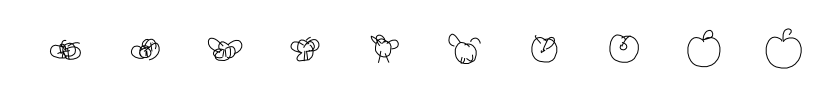

stroke3


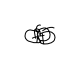

stroke5
stroke3


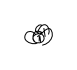

stroke5
stroke3


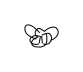

stroke5
stroke3


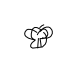

stroke5
stroke3


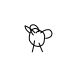

stroke5
stroke3


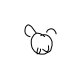

stroke5
stroke3


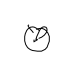

stroke5
stroke3


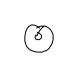

stroke5
stroke3


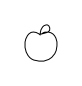

stroke5
stroke3


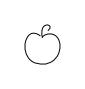

stroke5


In [28]:
# save the combined grid as a single long SVG
out_svg = './interpolations/latent_interpolation.svg'
os.makedirs(os.path.dirname(out_svg), exist_ok=True)
# draw_strokes will save the svg to the given filename and display it
draw_strokes(stroke_grid, svg_filename=out_svg)
# save each reconstructed stroke array to .npy files
out_dir = './interpolations/individual_strokes'
os.makedirs(out_dir, exist_ok=True)
for i, rec in enumerate(reconstructions):
  strokes = np.array(rec[0])
  print(detect_stroke_format(strokes))
  npy_path = os.path.join(out_dir, 'interp_{:02d}_s3.npy'.format(i))
  np.save(npy_path, strokes)
  
  # optional: also save a small SVG preview for each stroke (comment out if noisy)
  preview_svg = os.path.join(out_dir, 'interp_{:02d}.svg'.format(i))
  draw_strokes(strokes, svg_filename=preview_svg)

  strokes = to_stroke5(strokes)
  print(detect_stroke_format(strokes))
  npy_path = os.path.join(out_dir, 'interp_{:02d}_s5.npy'.format(i))
  np.save(npy_path, strokes)
  

## 读取npz/npy和画画

In [29]:
def safe_draw(s_arr, name_prefix='sample'):
    fmt = detect_stroke_format(s_arr)
    print('  shape/dtype:', getattr(s_arr,'shape',None), getattr(s_arr,'dtype',None), 'detected:', fmt)
    if fmt == 'stroke5':
        s3 = to_stroke3(s_arr)
        print('   converted stroke5 -> stroke3, new shape', s3.shape)
    else:
        s3 = s_arr
    # save each svg with unique name so files don't overwrite
    svg_out = os.path.join('/tmp', f'{name_prefix}.svg')
    draw_strokes(s3, svg_filename=svg_out)
    print('   saved/displayed svg:', svg_out)

npz keys: ['strokes']
key: strokes type: <class 'numpy.ndarray'> shape/dtype: (75, 3) float64
  shape/dtype: (75, 3) float64 detected: stroke3


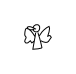

   saved/displayed svg: /tmp/sample_pred_cond_s3.npz_strokes.svg


In [30]:
import numpy as np, os
path = 'sampling_dir/angel/0/sample_pred_cond_s3.npz'  # 改成你要检查的文件
npz = np.load(path, allow_pickle=True)
print('npz keys:', npz.files)

for k in npz.files:#npz
    item = npz[k]
    print('key:', k, 'type:', type(item), 'shape/dtype:', getattr(item,'shape',None), getattr(item,'dtype',None))
    # case A: stored as object array (list of samples)
    if isinstance(item, np.ndarray) and item.dtype == object:
        for i, s in enumerate(item):
            s_arr = np.asarray(s)
            print(' sample', i)
            safe_draw(s_arr, name_prefix=f'{os.path.basename(path)}_{k}_{i}')
    # case B: stored as 2D strokes array (single sample)
    elif isinstance(item, np.ndarray) and item.ndim == 2 and item.shape[1] in (3,5):
        safe_draw(item, name_prefix=f'{os.path.basename(path)}_{k}')
    # case C: nested arrays (e.g., array of arrays not object-dtyped)
    else:
        try:
            for i, s in enumerate(item):
                s_arr = np.asarray(s)
                if isinstance(s_arr, np.ndarray) and s_arr.ndim == 2:
                    print(' nested sample', i, '->', s_arr.shape)
                    safe_draw(s_arr, name_prefix=f'{os.path.basename(path)}_{k}_{i}')
        except Exception as e:
            print(' skipping key', k, 'unhandled format:', e)


  shape/dtype: (74, 3) int16 detected: stroke3


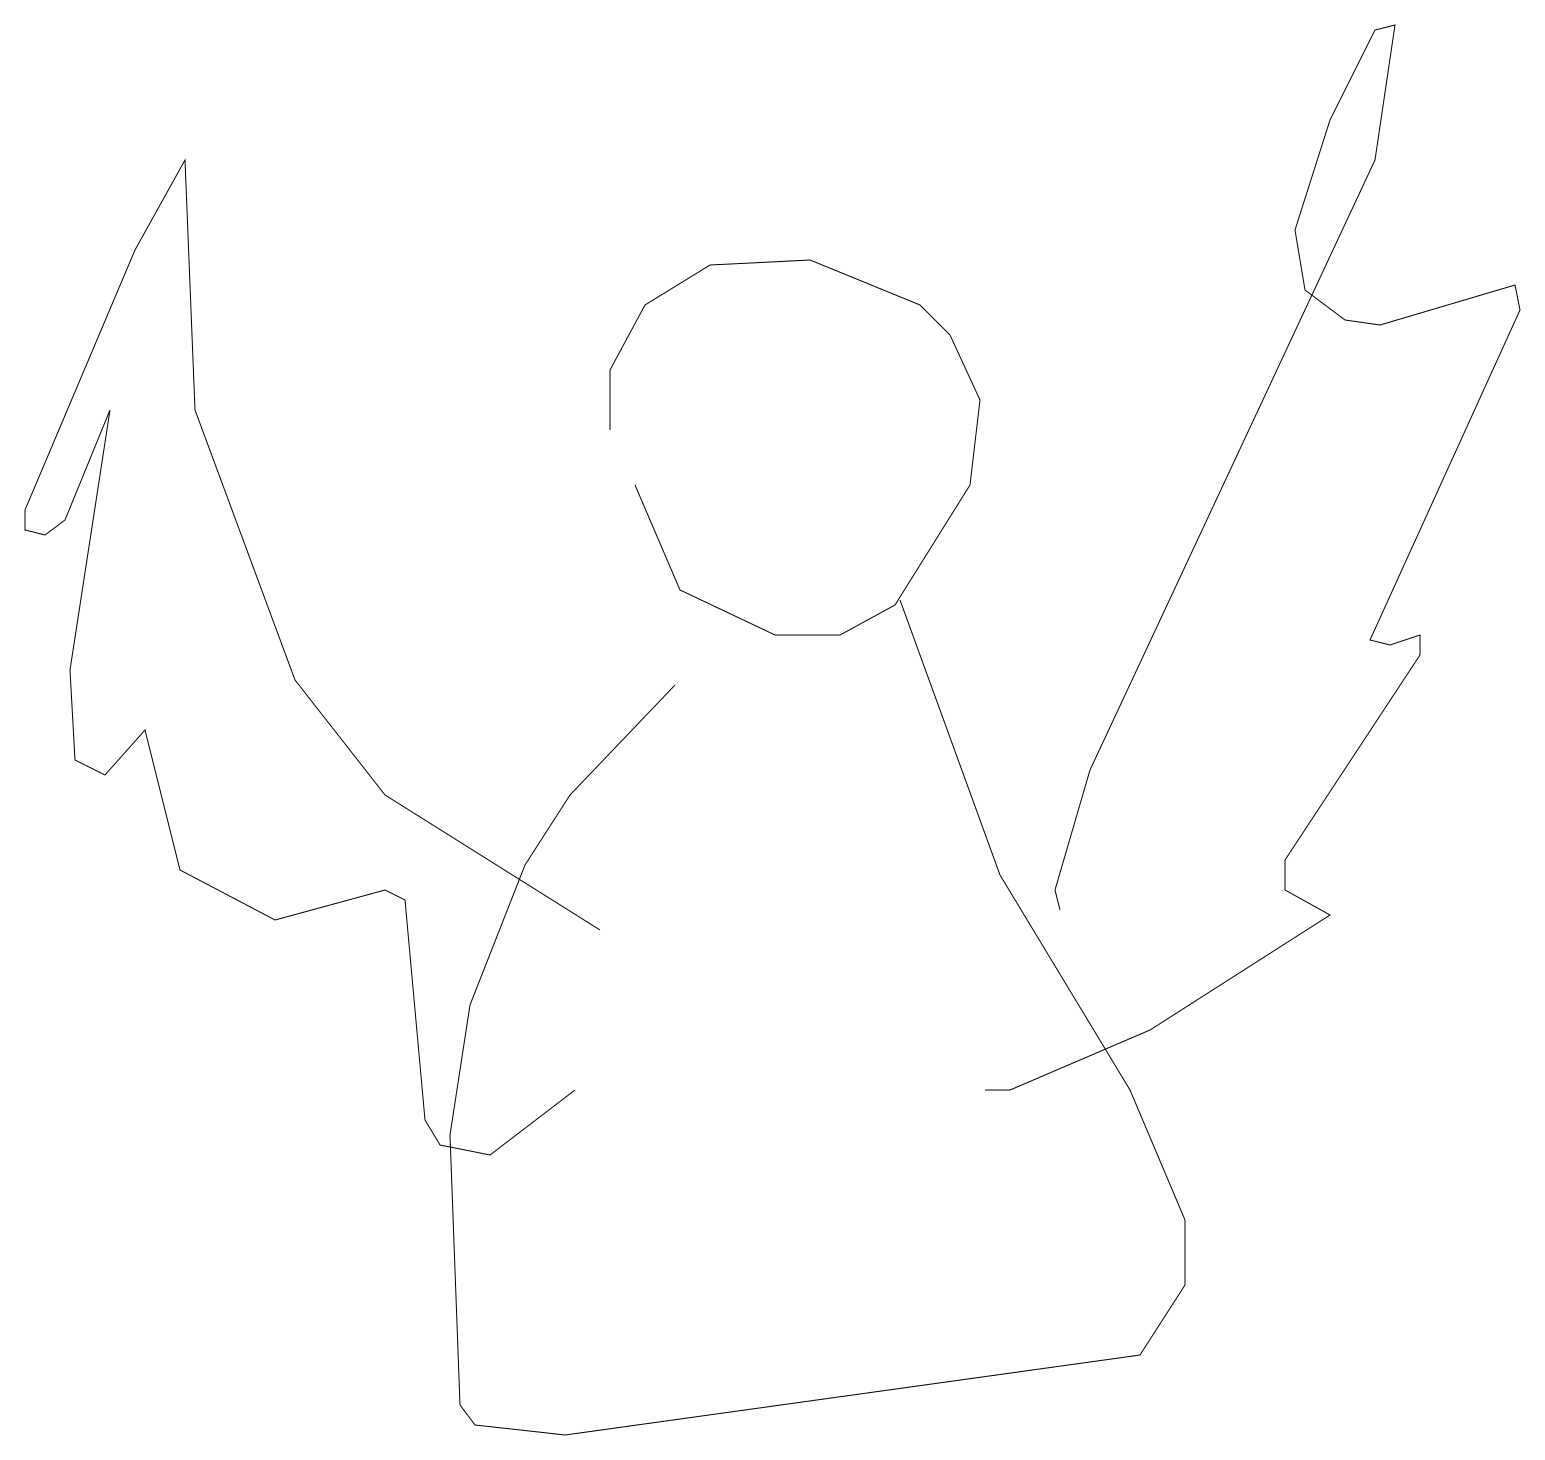

   saved/displayed svg: /tmp/sample.svg


In [31]:
import numpy as np, os
path = 'sampling_dir/angel/0/sample_gt.npy'  # 改成你要检查的文件
npy = np.load(path, allow_pickle=True)
safe_draw(npy)

# 生成数据

In [32]:
# Batch-encode QuickDraw datasets to z and save into ./test_z
out_dir = './test_z'
os.makedirs(out_dir, exist_ok=True)
qd_dir = './QuickDraw_generation'
files = [f for f in os.listdir(qd_dir) if f.endswith('.npz') or f.endswith('.npy')]
print('Found QuickDraw files:', files)

# quiet encoder that does not call draw_strokes
def encode_quiet(input_strokes):
    strokes = to_big_strokes(input_strokes, max_seq_len).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

count = 0
for fname in files:
    path = os.path.join(qd_dir, fname)
    base = os.path.splitext(fname)[0]
    print('Processing', fname)
    if fname.endswith('.npz'):
        npz = np.load(path, allow_pickle=True, encoding='latin1')
        for k in npz.files:
            item = npz[k]
            # case: object-dtype array (list of samples)
            if isinstance(item, np.ndarray) and item.dtype == object:
                for i, s in enumerate(item):
                    s_arr = np.asarray(s)
                    fmt = detect_stroke_format(s_arr)
                    if fmt == 'stroke5':
                        s3 = to_stroke3(s_arr)
                    else:
                        s3 = s_arr
                    try:
                        z = encode_quiet(s3)
                        np.save(os.path.join(out_dir, f'{base}_{k}_{i}_z.npy'), z)
                        count += 1
                    except Exception as e:
                        print('  Error encoding', base, k, i, e)
            # case: single 2D strokes array per key
            elif isinstance(item, np.ndarray) and item.ndim == 2 and item.shape[1] in (3,5):
                s_arr = item
                fmt = detect_stroke_format(s_arr)
                s3 = to_stroke3(s_arr) if fmt == 'stroke5' else s_arr
                try:
                    z = encode_quiet(s3)
                    np.save(os.path.join(out_dir, f'{base}_{k}_z.npy'), z)
                    count += 1
                except Exception as e:
                    print('  Error encoding', base, k, e)
            else:
                # try nested iteration fallback
                try:
                    for i, s in enumerate(item):
                        s_arr = np.asarray(s)
                        if isinstance(s_arr, np.ndarray) and s_arr.ndim == 2:
                            fmt = detect_stroke_format(s_arr)
                            s3 = to_stroke3(s_arr) if fmt == 'stroke5' else s_arr
                            try:
                                z = encode_quiet(s3)
                                np.save(os.path.join(out_dir, f'{base}_{k}_{i}_z.npy'), z)
                                count += 1
                            except Exception as e:
                                print('  Error encoding nested', base, k, i, e)
                except Exception as e:
                    print('  Skipping', base, k, 'unhandled format:', e)
    elif fname.endswith('.npy'):
        arr = np.load(path, allow_pickle=True, encoding='latin1')
        if isinstance(arr, np.ndarray) and arr.dtype == object:
            for i, s in enumerate(arr):
                s_arr = np.asarray(s)
                fmt = detect_stroke_format(s_arr)
                s3 = to_stroke3(s_arr) if fmt == 'stroke5' else s_arr
                try:
                    z = encode_quiet(s3)
                    np.save(os.path.join(out_dir, f'{base}_{i}_z.npy'), z)
                    count += 1
                except Exception as e:
                    print('  Error encoding', base, i, e)
        elif isinstance(arr, np.ndarray) and arr.ndim == 2:
            s_arr = arr
            fmt = detect_stroke_format(s_arr)
            s3 = to_stroke3(s_arr) if fmt == 'stroke5' else s_arr
            try:
                z = encode_quiet(s3)
                np.save(os.path.join(out_dir, f'{base}_z.npy'), z)
                count += 1
            except Exception as e:
                print('  Error encoding', base, e)

print('Finished. Saved', count, 'z vectors to', out_dir)


Found QuickDraw files: ['angel.npz', 'cat.npz', 'belt.npz', 'cake.npz', 'clock.npz', 'bus.npz', 'apple.npz', 'alarm_clock.npz', 'airplane.npz', 'butterfly.npz']
Processing angel.npz


KeyboardInterrupt: 

Ranks: [5, 1, 2, 5, 5, 2, 4, 4, 1, 4, 2, 3, 2, 5, 1, 1, 1, 1, 1, 4]


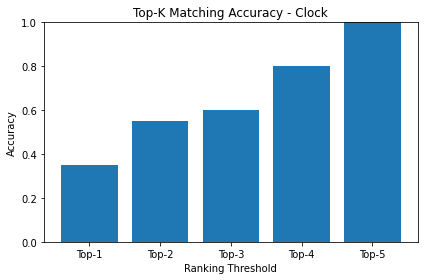

In [126]:
import matplotlib.pyplot as plt
import numpy as np


import csv
import io

raw_text = """sample,matched_correct_relpath,rank_of_correct,total_candidates
1067_z.npy,clock_test_1067_z.npy,5,5
1154_z.npy,clock_test_1154_z.npy,1,5
1497_z.npy,clock_test_1497_z.npy,2,5
1648_z.npy,clock_test_1648_z.npy,5,5
165_z.npy,clock_test_165_z.npy,5,5
1660_z.npy,clock_test_1660_z.npy,2,5
175_z.npy,clock_test_175_z.npy,4,5
1787_z.npy,clock_test_1787_z.npy,4,5
1947_z.npy,clock_test_1947_z.npy,1,5
1963_z.npy,clock_test_1963_z.npy,4,5
1986_z.npy,clock_test_1986_z.npy,2,5
2274_z.npy,clock_test_2274_z.npy,3,5
2282_z.npy,clock_test_2282_z.npy,2,5
319_z.npy,clock_test_319_z.npy,5,5
559_z.npy,clock_test_559_z.npy,1,5
633_z.npy,clock_test_633_z.npy,1,5
696_z.npy,clock_test_696_z.npy,1,5
743_z.npy,clock_test_743_z.npy,1,5
76_z.npy,clock_test_76_z.npy,1,5
977_z.npy,clock_test_977_z.npy,4,5
"""

f = io.StringIO(raw_text)
reader = csv.DictReader(f)

ranks = [int(row["rank_of_correct"]) for row in reader]

print("Ranks:", ranks)

# 示例：你的真实实验结果（请替换）
#ranks = [1, 3, 2, 3, 3, 4, 2, 5, 4, 5, 2, 3, 2, 2, 1, 3, 5, 1, 5, 3]

# 统计 Top-K 命中率
top1 = sum(r <= 1 for r in ranks) / len(ranks)
top2 = sum(r <= 2 for r in ranks) / len(ranks)
top3 = sum(r <= 3 for r in ranks) / len(ranks)
top4 = sum(r <= 4 for r in ranks) / len(ranks)
top5 = sum(r <= 5 for r in ranks) / len(ranks)

topk_acc = [top1, top2, top3, top4, top5]
k_labels = ['Top-1', 'Top-2', 'Top-3', 'Top-4', 'Top-5' ]

plt.figure(figsize=(6, 4))
plt.bar(k_labels, topk_acc)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Ranking Threshold')
plt.title('Top-K Matching Accuracy - Clock')

plt.tight_layout()
plt.savefig('topk_accuracy_clock.jpg')
plt.show()
